In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import multiprocessing
import scipy.special
import ghalton
import numpy as np
import numpy.fft as fft
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')

In [3]:
from utils import clean,to_radian,hann,res_to_rad
from Bessel_Interp import generate_halton_points
from rotation_2d import rot_cost_func, imrotate
from visualize import plot_cost_func
from cost_functions import cf_ssd
from mask import sphere_mask

In [ ]:
# Load Data
dict_10mm = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/dict_10mm.p','rb'))
dict_8mm = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/dict_8mm.p','rb'))
dict_6_4mm = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/dict_6_4mm.p','rb'))

In [4]:
# Functions to plot inidividual cost functions
def plot_results(cost_dict, res, interp = 'linear', rot='iso'):
    axes = ['axis0','axis1','axis2']
    degrees = np.arange(0.5, 5.5, 0.5)
    for i, ax in enumerate(axes):
        for deg in degrees:
            thetas = np.arange(-deg-3,deg+3,0.01)
            plt.figure(figsize=[12,4])
            for idx, coil in enumerate(['head', 'body']):
                cost = cost_dict[i][deg][coil]
                plt.subplot(1,2,idx+1)
                plot_cost_func(thetas, cost, res, interp, str(deg)+'_'+rot+'_'+ax, coil)
            plt.show()
            
def get_min(cost_dict, res, rot='iso'):
    # Gets the minimum search angle for all 
    min_ls = []
    axes = ['axis0','axis1','axis2']
    degrees = np.arange(0.5, 5.5, 0.5)
    for i, ax in enumerate(axes):
        for deg in degrees:
            thetas = np.arange(-deg-3,deg+3,0.01)
            for idx, coil in enumerate(['head', 'body']):
                cost = cost_dict[i][deg][coil]
                min_ls.append([deg,abs(thetas[np.argmin(cost,axis=0)]),idx])
    return np.array(min_ls)



In [5]:
def get_min(cost_dict, res, rot='iso'):
    # Gets the minimum search angle for all 
    min_ls = []
    axes = ['axis0','axis1','axis2']
    degrees = np.arange(0.5, 5.5, 0.5)
    for i, ax in enumerate(axes):
        for deg in degrees:
            thetas = np.arange(-deg-3,deg+3,0.01)
            for idx, coil in enumerate(['head', 'body']):
                cost = cost_dict[i][deg][coil]
                min_ls.append([deg,abs(thetas[np.argmin(cost,axis=0)]),idx])
    return np.array(min_ls)

# Function that does scatter plot of results
def scatter_plot(cost_dict, res, rot='iso'):
    colors = ['red','blue','green']
    axes = ['axis0','axis1','axis2']
    degrees = np.arange(0.5, 5.5, 0.5)
    for i, ax in enumerate(axes):
        for deg in degrees:
            thetas = np.arange(-deg-3,deg+3,0.01)
            for idx, coil in enumerate(['head', 'body']):
                if(deg == 0.5):
                    label = coil +'_' +ax
                else:
                    label=None
                if(idx == 0):
                    m = 'o'
                else:
                    m = 'x'
                cost = cost_dict[i][deg][coil]
                y = abs(thetas[np.argmin(cost,axis=0)])
                plt.scatter(deg, y, s = 80, c = colors[i],alpha = 0.6,marker=m,label = label)
    plt.plot([0,6],[0,6],c='black')
    plt.xlim([0,6])
    plt.ylim([0,6])
    plt.legend(loc=4)
    plt.title('Search Results for %s Resolution' %res)
    #plt.show()

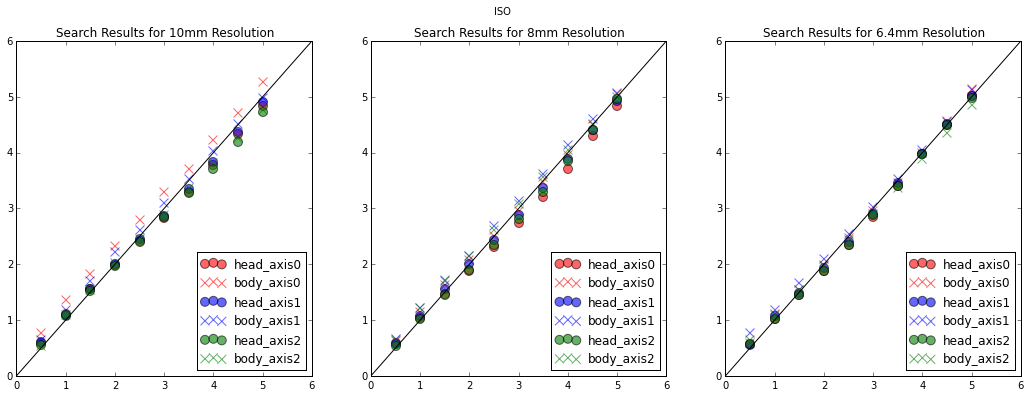

In [8]:
# Cubic iso
#10mm
cost_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july30_cubic_iso_10mm.p','rb'))
# 8mm
cost_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july30_cubic_iso_8mm.p','rb'))
#6.4mm
cost_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july30_cubic_iso_6_4mm.p','rb'))

# Scatter Plot
plt.figure(figsize = [18,6])
plt.subplot(1,3,1)
scatter_plot(cost_dict_10,'10mm')
plt.subplot(1,3,2)
scatter_plot(cost_dict_8,'8mm')
plt.subplot(1,3,3)
scatter_plot(cost_dict_6_4,'6.4mm')
plt.suptitle('ISO')
plt.show()

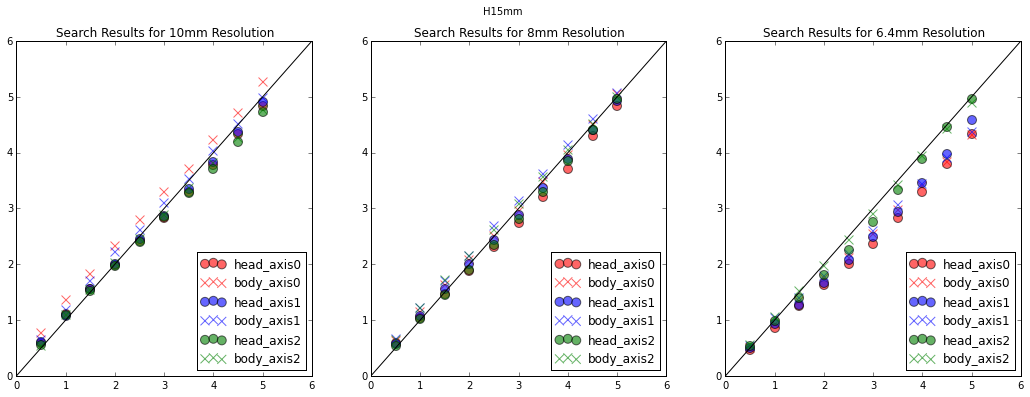

In [9]:
# Cubic H15mm
#10mm
cost_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july30_cubic_H15mm_10mm.p','rb'))
# 8mm
cost_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july30_cubic_H15mm_8mm.p','rb'))
#6.4mm
cost_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july30_cubic_H15mm_6_4mm.p','rb'))

# Scatter Plot
plt.figure(figsize = [18,6])
plt.subplot(1,3,1)
scatter_plot(cost_dict_10,'10mm')
plt.subplot(1,3,2)
scatter_plot(cost_dict_8,'8mm')
plt.subplot(1,3,3)
scatter_plot(cost_dict_6_4,'6.4mm')
plt.suptitle('H15mm')
plt.show()

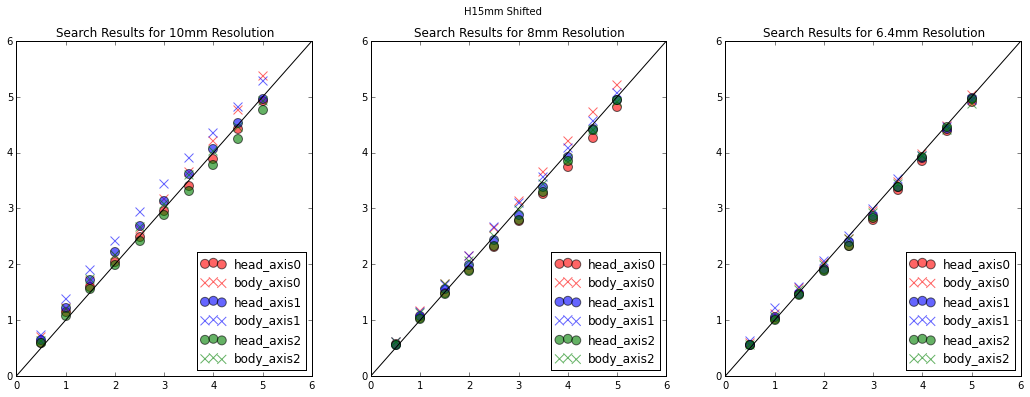

In [10]:
# Cubic H15mm registered with center shifted
#10mm
cost_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/newjuly30_cubic_H15mm_10mm.p','rb'))
# 8mm
cost_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/newjuly30_cubic_H15mm_8mm.p','rb'))
#6.4mm
cost_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/newjuly30_cubic_H15mm_6_4mm.p','rb'))

# Scatter Plot
plt.figure(figsize = [18,6])
plt.subplot(1,3,1)
scatter_plot(cost_dict_10,'10mm')
plt.subplot(1,3,2)
scatter_plot(cost_dict_8,'8mm')
plt.subplot(1,3,3)
scatter_plot(cost_dict_6_4,'6.4mm')
plt.suptitle('H15mm Shifted')
plt.show()

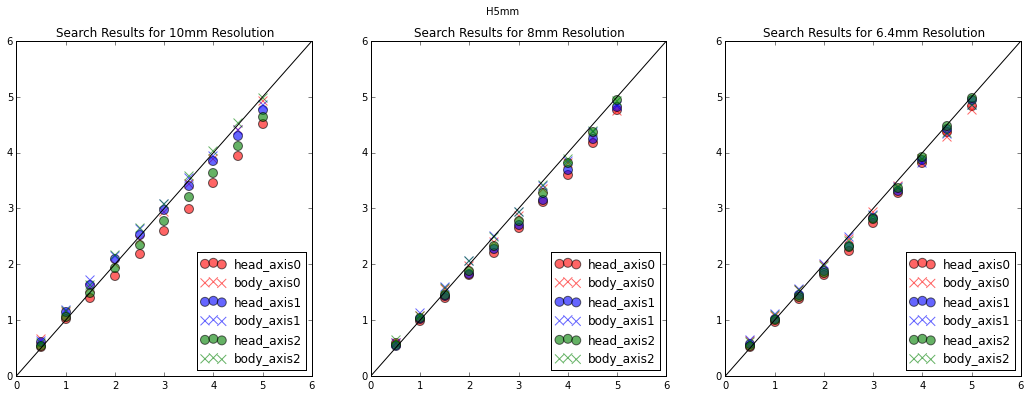

In [11]:
# Cubic H5mm
#10mm
cost_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july30_cubic_H5mm_10mm.p','rb'))
# 8mm
cost_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july30_cubic_H5mm_8mm.p','rb'))
#6.4mm
cost_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july30_cubic_H5mm_6_4mm.p','rb'))

# Scatter Plot
plt.figure(figsize = [18,6])
plt.subplot(1,3,1)
scatter_plot(cost_dict_10,'10mm')
plt.subplot(1,3,2)
scatter_plot(cost_dict_8,'8mm')
plt.subplot(1,3,3)
scatter_plot(cost_dict_6_4,'6.4mm')
plt.suptitle('H5mm')
plt.show()

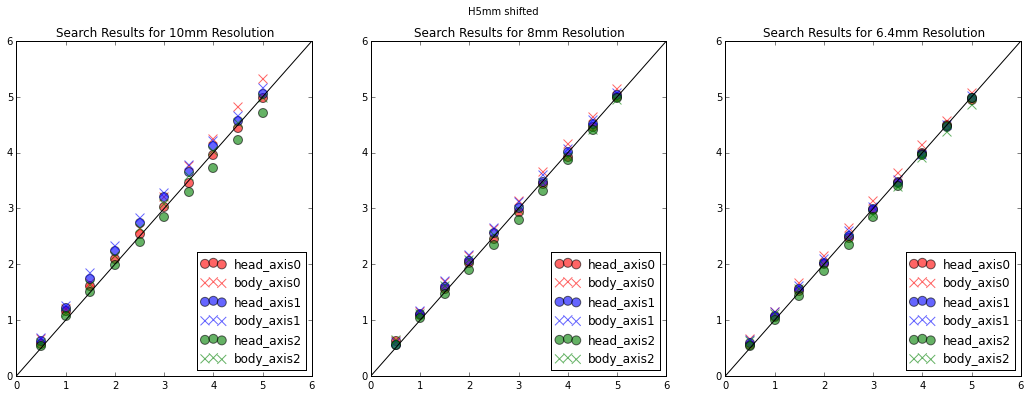

In [12]:
# Cubic H5mm registered with center shifted
#10mm
cost_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/newjuly30_cubic_H5mm_10mm.p','rb'))
# 8mm
cost_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/newjuly30_cubic_H5mm_8mm.p','rb'))
#6.4mm
cost_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/newjuly30_cubic_H5mm_6_4mm.p','rb'))

# Scatter Plot
plt.figure(figsize = [18,6])
plt.subplot(1,3,1)
scatter_plot(cost_dict_10,'10mm')
plt.subplot(1,3,2)
scatter_plot(cost_dict_8,'8mm')
plt.subplot(1,3,3)
scatter_plot(cost_dict_6_4,'6.4mm')
plt.suptitle('H5mm shifted')
plt.show()

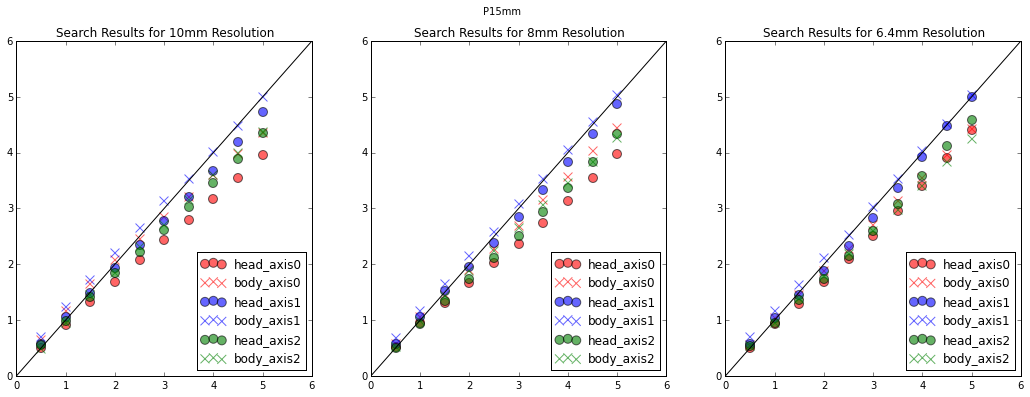

In [13]:
# Cubic P15mm
#10mm
cost_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july30_cubic_P15mm_10mm.p','rb'))
# 8mm
cost_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july30_cubic_P15mm_8mm.p','rb'))
#6.4mm
cost_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july30_cubic_P15mm_6_4mm.p','rb'))

# Scatter Plot
plt.figure(figsize = [18,6])
plt.subplot(1,3,1)
scatter_plot(cost_dict_10,'10mm')
plt.subplot(1,3,2)
scatter_plot(cost_dict_8,'8mm')
plt.subplot(1,3,3)
scatter_plot(cost_dict_6_4,'6.4mm')
plt.suptitle('P15mm')
plt.show()

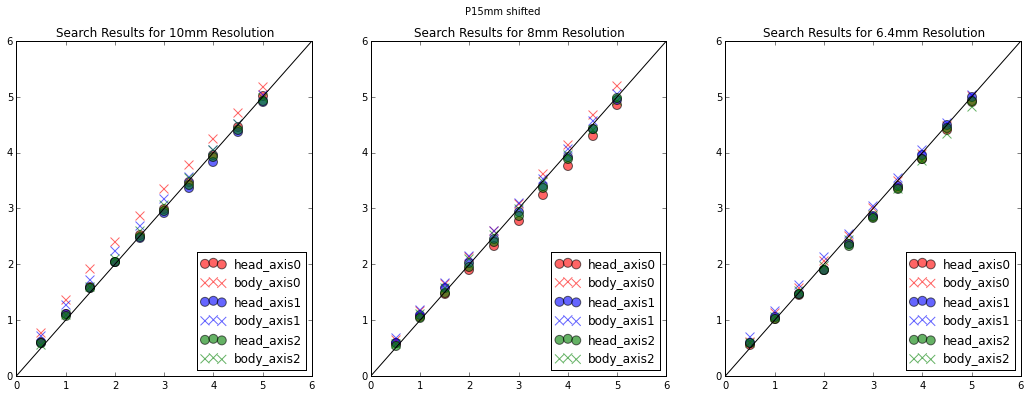

In [14]:
# Cubic P15mm registered with center shifted
#10mm
cost_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/newjuly30_cubic_P15mm_10mm.p','rb'))
# 8mm
cost_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/newjuly30_cubic_P15mm_8mm.p','rb'))
#6.4mm
cost_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/newjuly30_cubic_P15mm_6_4mm.p','rb'))

# Scatter Plot
plt.figure(figsize = [18,6])
plt.subplot(1,3,1)
scatter_plot(cost_dict_10,'10mm')
plt.subplot(1,3,2)
scatter_plot(cost_dict_8,'8mm')
plt.subplot(1,3,3)
scatter_plot(cost_dict_6_4,'6.4mm')
plt.suptitle('P15mm shifted')
plt.show()

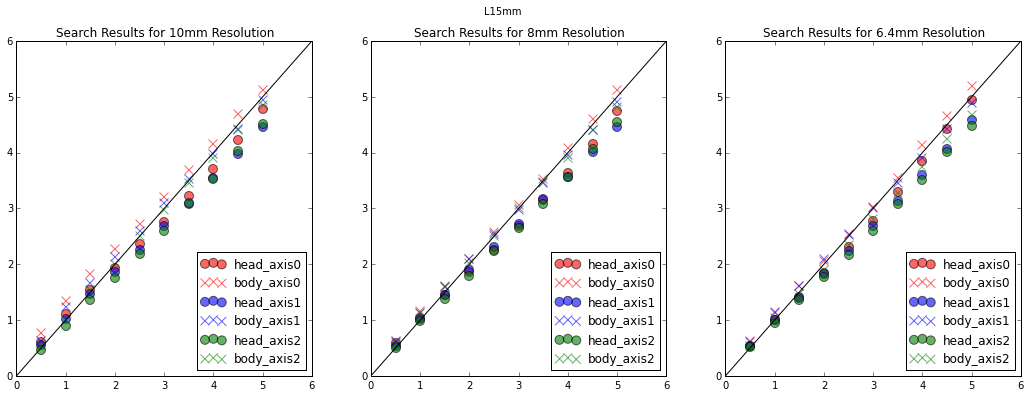

In [15]:
# Cubic L15mm
#10mm
cost_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july30_cubic_L15mm_10mm.p','rb'))
# 8mm
cost_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july30_cubic_L15mm_8mm.p','rb'))
#6.4mm
cost_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july30_cubic_L15mm_6_4mm.p','rb'))

# Scatter Plot
plt.figure(figsize = [18,6])
plt.subplot(1,3,1)
scatter_plot(cost_dict_10,'10mm')
plt.subplot(1,3,2)
scatter_plot(cost_dict_8,'8mm')
plt.subplot(1,3,3)
scatter_plot(cost_dict_6_4,'6.4mm')
plt.suptitle('L15mm')
plt.show()

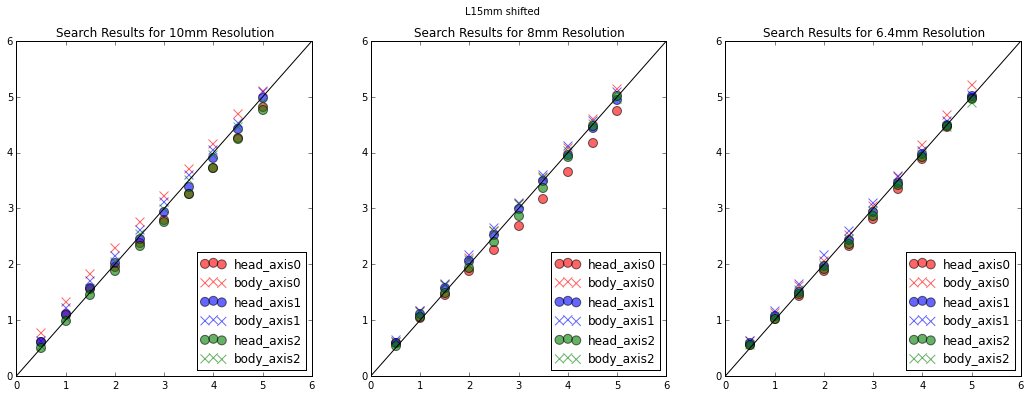

In [16]:
# Cubic L15mm registered with center shifted
#10mm
cost_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/newjuly30_cubic_L15mm_10mm.p','rb'))
# 8mm
cost_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/newjuly30_cubic_L15mm_8mm.p','rb'))
#6.4mm
cost_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/newjuly30_cubic_L15mm_6_4mm.p','rb'))

# Scatter Plot
plt.figure(figsize = [18,6])
plt.subplot(1,3,1)
scatter_plot(cost_dict_10,'10mm')
plt.subplot(1,3,2)
scatter_plot(cost_dict_8,'8mm')
plt.subplot(1,3,3)
scatter_plot(cost_dict_6_4,'6.4mm')
plt.suptitle('L15mm shifted')
plt.show()